# TEACHER STUDENT COLLABORATION

In this colab, we will learn how to fine tune small LLM Model with help of Larger Language Model. Then in this concept, you are going to 
teach SMALL LLM Model with Larger LLM Model. 
1. Importing Necessary libraries
2. Hugging face, pytorch
3. Dataset Loading and Preprocessing
4. Train , Test and Validation split from original dataset.
5. Tokenize Dataset
6. Prepare Training Class
7. Train the Model
8. Save Model for Inference
9. Use Student and Teacher Model for Comparion of Results 

In [1]:
!pip install transformers 
!pip install numpy
!pip install accelerate
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 10.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.3/401.3 kB 9.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 785.0/785.0 kB 9.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 10.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 5.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/

In [3]:
!pip3 install torch torchvision torchaudio

In [4]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
from transformers import EvalPrediction
from sklearn.metrics import accuracy_score
import numpy as np


2024-05-25 09:51:15.817359: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-25 09:51:15.843598: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Manage Dataset

In [63]:
# Load and tokenize the dataset
dataset2 = load_dataset('glue', 'sst2')

# Visualize Dataset

# BERT SMALL & LARGE INITIALIZATION AND LOADING, MOVING TO CUDA DEVICE

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


In [ ]:

teacher_model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=2)
student_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

teacher_model = teacher_model.to(device)
student_model = student_model.to(device)

In [7]:
# Function to tokenize the data
def tokenize_data(example):
    return tokenizer(example['sentence'], padding="max_length", truncation=True)



In [9]:
# Load and tokenize the dataset
dataset = load_dataset('glue', 'sst2')

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

# Dataset Mapping

In [11]:

dataset = dataset.map(tokenize_data, batched=True)

# DistillationTraner with Loss of Two Model

In [19]:
class DistillationTraner(Trainer):

    def compute_loss(self, student_model, inputs, return_outputs=False):
        # Move all input tensors to the correct device
        inputs = {k: v.to(device) for k, v in inputs.items() if isinstance(v, torch.Tensor)}

        # here we do training with student model
        outputs_of_students = student_model(**inputs)
        student_loss =  outputs_of_students.loss

        # here we only inference with teacher model
        with torch.no_grad():
            teacher_outputs = teacher_model(**inputs)

        # distillation loss
        distillation_loss = torch.nn.MSELoss()(outputs_of_students.logits, teacher_outputs.logits)

        # total_loss 
        total_loss = student_loss + distillation_loss

        return (total_loss, outputs) if return_outputs else total_loss
        
        

# Training Arguments needs to be defined carefully, here we will create results , and define some hyperparameters.

# Hugging Face
This parameter is typically used 
in conjunction with load_best_model_at_end and evaluation_strategy. Setting load_best_model_at_end to
True ensures that the model with the best validation score according to the metric_for_best_model is loaded
at the end of training. The evaluation_strategy determines how frequently the model is evaluated during training

In [17]:
training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs=1,
    per_device_train_batch_size=16,  # Perform evaluation at the end of each epoch
    evaluation_strategy="epoch",  # Perform evaluation at the end of each epoch
    save_strategy = "epoch",  # Save the model at the end of each epoch
    logging_dir = './logs',
    logging_steps = 10,
    load_best_model_at_end=True, # Optional: Load the best model at the end of training Whether or not to load the best model found during training at the end of training. When this option is enabled, the best checkpoint will always be saved. See
    metric_for_best_model = 'accuracy'
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Metrics Calculation
compute_metrics (Callable[[EvalPrediction], Dict], optional) — 
The function that will be used to compute metrics at evaluation. Must take a EvalPrediction and return a dictionary string to metric values. Note When passing TrainingArgs with batch_eval_metrics set to True, your compute_metrics function must take a boolean compute_result argument. This will be triggered after the last eval batch to signal that the function needs to calculate and return the global summary statistics rather than accumulating the batch-level statistics.


In [ ]:
def compute_metrics(p:EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return{"accuracy" : accuracy_score(p.labels_ids, preds)} 

# Initialize the trainer with compute_metrics
trainer = DistillationTraner(
    model=student_model,
    args=training_args,
    train_dataset=dataset['train'],  # Ensure you have a train dataset
    eval_dataset=dataset['validation'],  # Ensure you have a validation dataset
    compute_metrics=compute_metrics,
)

In [18]:
trainer.train()
student_model.save_pretrained("student_model_bert_fine_tuned")
tokenizer.save_pretrained("student_model_bert_fine_tuned")


Epoch,Training Loss,Validation Loss,Accuracy
1,0.723000,0.718285,0.500000


('student_model_bert_fine_tuned/tokenizer_config.json',
 'student_model_bert_fine_tuned/special_tokens_map.json',
 'student_model_bert_fine_tuned/vocab.txt',
 'student_model_bert_fine_tuned/added_tokens.json')

In [24]:
teacher_model.save_pretrained("teacher_model_bert_fine_tuned")
tokenizer.save_pretrained("teacher_model_bert_fine_tuned")

('teacher_model_bert_fine_tuned/tokenizer_config.json',
 'teacher_model_bert_fine_tuned/special_tokens_map.json',
 'teacher_model_bert_fine_tuned/vocab.txt',
 'teacher_model_bert_fine_tuned/added_tokens.json')

In [30]:
!zip -r student_model_bert_fine_tuned.zip /tf/tensorflow-tutorials/student_model_bert_fine_tuned

/usr/bin/sh: 1: zip: not found


In [139]:
!zip -r teacher_model_bert_fine_tuned.zip /tf/tensorflow-tutorials/teacher_model_bert_fine_tuned

  adding: tf/tensorflow-tutorials/teacher_model_bert_fine_tuned/ (stored 0%)
  adding: tf/tensorflow-tutorials/teacher_model_bert_fine_tuned/special_tokens_map.json (deflated 42%)
  adding: tf/tensorflow-tutorials/teacher_model_bert_fine_tuned/vocab.txt (deflated 53%)
  adding: tf/tensorflow-tutorials/teacher_model_bert_fine_tuned/tokenizer_config.json (deflated 75%)
  adding: tf/tensorflow-tutorials/teacher_model_bert_fine_tuned/config.json (deflated 48%)
  adding: tf/tensorflow-tutorials/teacher_model_bert_fine_tuned/model.safetensors (deflated 7%)


In [21]:
!unzip /tf/tensorflow-tutorials/teacher_model_bert_fine_tuned.zip -d .

Archive:  /tf/tensorflow-tutorials/teacher_model_bert_fine_tuned.zip
   creating: ./tf/tensorflow-tutorials/teacher_model_bert_fine_tuned/
  inflating: ./tf/tensorflow-tutorials/teacher_model_bert_fine_tuned/special_tokens_map.json  
  inflating: ./tf/tensorflow-tutorials/teacher_model_bert_fine_tuned/vocab.txt  
  inflating: ./tf/tensorflow-tutorials/teacher_model_bert_fine_tuned/tokenizer_config.json  
  inflating: ./tf/tensorflow-tutorials/teacher_model_bert_fine_tuned/config.json  
  inflating: ./tf/tensorflow-tutorials/teacher_model_bert_fine_tuned/model.safetensors  


In [22]:
!unzip /tf/tensorflow-tutorials/student_model_bert_fine_tuned.zip -d .

Archive:  /tf/tensorflow-tutorials/student_model_bert_fine_tuned.zip
   creating: ./tf/tensorflow-tutorials/student_model_bert_fine_tuned/
  inflating: ./tf/tensorflow-tutorials/student_model_bert_fine_tuned/special_tokens_map.json  
  inflating: ./tf/tensorflow-tutorials/student_model_bert_fine_tuned/vocab.txt  
  inflating: ./tf/tensorflow-tutorials/student_model_bert_fine_tuned/tokenizer_config.json  
  inflating: ./tf/tensorflow-tutorials/student_model_bert_fine_tuned/config.json  
  inflating: ./tf/tensorflow-tutorials/student_model_bert_fine_tuned/model.safetensors  


# Prepare models FOR INFERENCE

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

class Inference:

    def __init__(self, tokenizer_path, base_model_path, student_model_path,ground_truth):
        self.__tokenizer_path = tokenizer_path

        self.__teacher_model_path  = base_model_path
        self.__student_model_path = student_model_path
        self.__ground_truth = ground_truth


    def load_tokenizer(self):
        
        tokenizer = BertTokenizer.from_pretrained( self.__tokenizer_path)
        
        return tokenizer


    def load_model(self, model_path):
        model = BertForSequenceClassification.from_pretrained(model_path)
        
        model.eval()

        if torch.cuda.is_available():
            
            model = model.cuda()
            
        return model

    def predict(self, model, inputs):
        
        with torch.inference_mode():
            
            outputs = model(**inputs)
            
            
            predictions = torch.argmax(outputs.logits, dim=-1)
       
        return predictions

    
    def postprocess(self, predictions, class_names=['Negative', 'Positive']):
        
        """ Convert prediction indices to class names. """
        
        classes = [class_names[pred.item()]  for pred in predictions]
        
        return classes   

    def run(self, texts):
        tokenizer = self.load_tokenizer()
        
        student_model = self.load_model(self.__student_model_path)
       
        teacher_model = self.load_model(self.__teacher_model_path)

        results = []
        
        
        all_student_predictions = []
        all_teacher_predictions = []
        all_ground_truth = []
        
        for text, label in zip(texts, self.__ground_truth):
            encoded_inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt")
            
            if torch.cuda.is_available():
                encoded_inputs = {k: v.cuda() for k, v in encoded_inputs.items()}

            student_predictions = self.predict(student_model, encoded_inputs).detach().cpu()
            teacher_predictions = self.predict(teacher_model, encoded_inputs).detach().cpu()
           
            
            all_student_predictions.extend(student_predictions.numpy())
            all_teacher_predictions.extend(teacher_predictions.numpy())
            all_ground_truth.append(label)
            
            student_results_human = self.postprocess(student_predictions)
            teacher_results_human = self.postprocess(teacher_predictions)

            results.append((text, student_results_human, teacher_results_human))
            
            if 'Positive' in student_results_human and 'Positive' in teacher_results_human:
                print(f"{text}: Student and Teacher results to POSITIVE Feedback\n")
                print("=========================================================")
            
            elif 'Positive' in student_results_human or 'Positive' in teacher_results_human:
                  print(f"{text}: Student or Teacher results to POSITIVE Feedback\n")
                
        return results, (all_ground_truth, all_student_predictions, all_teacher_predictions)

    def plot(self, y_true, y_pred, model_title, save_dir):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title(f'Confusion Matrix_{model_title}')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt_path = os.path.join(save_dir, f'{model_title}_confusion_matrix.png')
        plt.savefig(plt_path)
        plt.show()
       
        
        # ROC Curve
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt_path = os.path.join(save_dir, f'{model_title}_roc_curve.png')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig(plt_path)
        plt.show()
       
                

In [57]:
tokenizer_path = '/tf/tensorflow-tutorials/tf/tensorflow-tutorials/student_model_bert_fine_tuned/'
student_model = '/tf/tensorflow-tutorials/tf/tensorflow-tutorials/student_model_bert_fine_tuned/'
teacher_model = '/tf/tensorflow-tutorials/tf/tensorflow-tutorials/teacher_model_bert_fine_tuned'

inference_engine = Inference(tokenizer_path,teacher_model, student_model, dataset['train']['label'][0:100])

In [58]:
results, (all_ground_truth, all_student_predictions, all_teacher_predictions) = inference_engine.run(dataset['train']['sentence'][0:100])

comes from the brave , uninhibited performances : Student or Teacher results to POSITIVE Feedback

covers this territory with wit and originality , suggesting that with his fourth feature : Student or Teacher results to POSITIVE Feedback



# CONVERT LIST TO NUMPY ARRAY

In [59]:
all_ground_truth, all_student_predictions, all_teacher_predictions = np.array(all_ground_truth), np.array( all_student_predictions), np.array(all_teacher_predictions)

In [60]:
type(all_ground_truth)

numpy.ndarray

# plot confusion matrix and roc curve

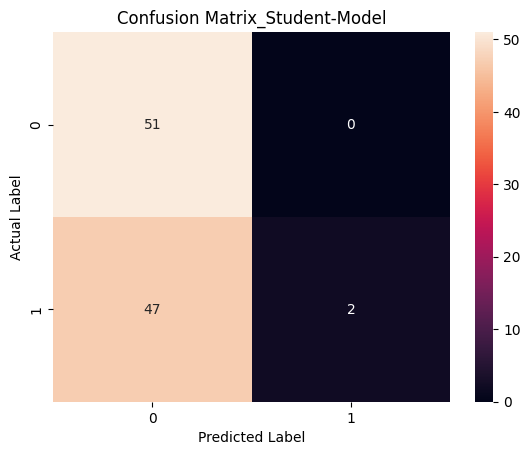

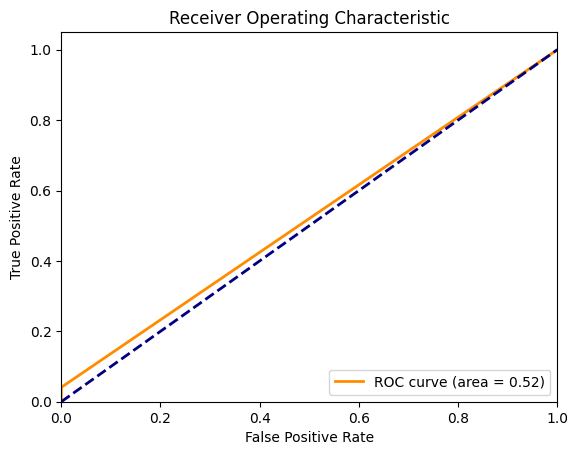

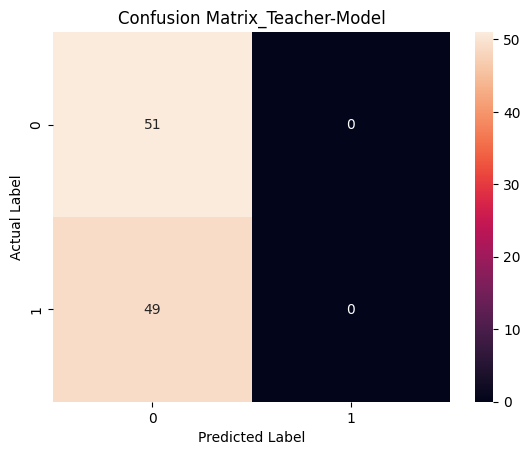

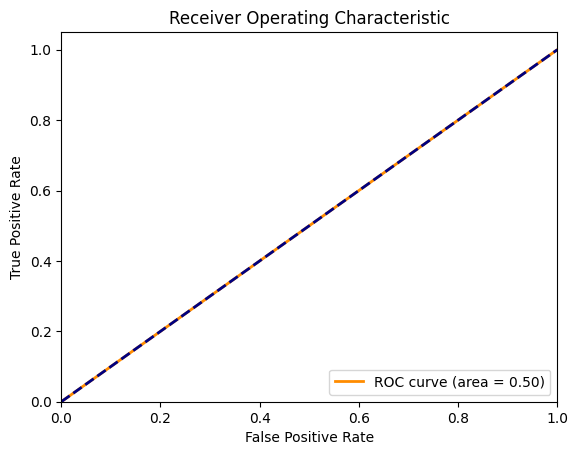

In [61]:
# Plot for student model
inference_engine.plot(all_ground_truth,  all_student_predictions, 'Student-Model', 'plots')
# Plot for teacher model
inference_engine.plot(all_ground_truth, all_teacher_predictions, 'Teacher-Model', 'plots')
   
    

In [62]:
unique, counts = np.unique(all_ground_truth, return_counts=True)
unique, counts

(array([0, 1]), array([51, 49]))

# CONGRATULATONS